# Atividade 7

Feita por Gabriel Cesário Silva Martins - 180100912

Instalando a bib com o dataset.

In [ ]:
!pip install tensorflow-datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Dense,Conv1D,Embedding,GlobalMaxPooling1D,MaxPooling1D,Activation,Flatten,LSTM,SimpleRNN,Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import SGD

Carregando os datasets

In [ ]:
ds_train = tfds.load('snli', split = 'train[50%:]', shuffle_files=True)
ds_valid = tfds.load('snli', split = 'validation', shuffle_files=False)
ds_test  = tfds.load('snli', split = 'test', shuffle_files=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/snli/1.1.0.incompleteY8PF3Q/snli-test.tfrecord*...:   0%|          | 0/10000 […

Generating validation examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/snli/1.1.0.incompleteY8PF3Q/snli-validation.tfrecord*...:   0%|          | 0/1…

Generating train examples...:   0%|          | 0/550152 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/snli/1.1.0.incompleteY8PF3Q/snli-train.tfrecord*...:   0%|          | 0/550152…

Dataset snli downloaded and prepared to ~/tensorflow_datasets/snli/1.1.0. Subsequent calls will reuse this data.


E convertendo para dataset do pandas

In [ ]:
df_train = tfds.as_dataframe(ds_train)
df_valid = tfds.as_dataframe(ds_valid)
df_test  = tfds.as_dataframe(ds_test) 

In [ ]:
df_train.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 275076 entries, 0 to 275075
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   hypothesis  275076 non-null  object
 1   label       275076 non-null  int64 
 2   premise     275076 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.3+ MB


Função para decodificar os bytes das colunas em strings reais.

In [ ]:
def processa_df(df):
  decoder = lambda arg: arg.decode();

  df['hypothesis'] = df['hypothesis'].apply(decoder)
  df['premise'] = df['premise'].apply(decoder)

In [ ]:
df_valid.head()

,hypothesis,label,premise
0,b'The girl is wearing a green striped dress.',2,b'A girl in a flower dress is running on sand.'
1,b'Two people are dancing on a stage.',0,b'A lady and a man are on stage dancing with f...
2,b'A professional soccer player holds the socce...,1,b'A soccer player wearing white shorts and an ...
3,b'A person is singing into a microphone.',0,b'A blond singer wearing a black shirt is sing...
4,b'A person in red and black falling through th...,2,b'A person dressed in red and black outside a ...


Verificando as labels. Apesar da documentação citar 3 classes, temos 4 no total. Não entendi o porquê da classe -1 (não se encaixa em nenhuma classe?).

In [ ]:
labels = dict()
for l in df_test.label:
  if l in labels:
    labels[l] += 1
  else:
    labels[l] = 1

labels

{0: 3368, 1: 3219, 2: 3237, -1: 176}

E tratando os datasets.

In [ ]:
processa_df(df_test)
processa_df(df_valid)
processa_df(df_train)

df_test.head()

,hypothesis,label,premise
0,A girl is entertaining on stage,0,A girl in a blue leotard hula hoops on a stage...
1,A group of people posing in front of a body of...,0,A group of people taking pictures on a walkway...
2,The group of people aren't inide of the building.,0,Many people standing outside of a place talkin...
3,The people are taking a carriage ride.,0,Three people are riding a carriage pulled by f...
4,Two girls are getting ready to ride horses.,1,Two girls feeding a horse an apple.


Juntando hipóteses com premissas

In [ ]:
df_train['hip_premise'] = df_train['hypothesis'] + ' ' + df_train['premise']
df_valid['hip_premise'] = df_valid['hypothesis'] + ' ' + df_valid['premise']
df_test['hip_premise']  = df_test['hypothesis']  + ' ' + df_test['premise']

In [ ]:
# df_train.drop(columns='hip_premise')

In [ ]:
df_train.label

0         0
1         0
2         0
3         0
4         0
         ..
275071    0
275072    0
275073    0
275074    1
275075    1
Name: label, Length: 275076, dtype: int64

In [ ]:
df_train['label'] = pd.Categorical(df_train['label'])
y_train_int = df_train['label'].cat.codes

df_valid['label'] = pd.Categorical(df_valid['label'])
y_valid_int = df_valid['label'].cat.codes

df_test['label'] = pd.Categorical(df_test['label'])
y_test_int = df_test['label'].cat.codes

In [ ]:
y_train = to_categorical(y_train_int)
y_valid = to_categorical(y_valid_int)
y_test = to_categorical(y_test_int)

## Numericalização

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['hip_premise'])
# tokenizer.fit_on_texts(df_train['premise'])
# tokenizer.fit_on_texts(df_train['hypothesis'])

In [ ]:
vocab_size = len(tokenizer.word_counts)
len(tokenizer.word_counts)

27908

In [ ]:
train_sequences = dict()


train_sequences = tokenizer.texts_to_sequences(df_train['hip_premise'])
# train_sequences['premise']     = tokenizer.texts_to_sequences(df_train['premise'])
# train_sequences['hypothesis']  = tokenizer.texts_to_sequences(df_train['hypothesis'])

In [ ]:
print(df_train['hip_premise'][0])
print(train_sequences[0])

A child reaches up. a child reaches up into the air as a woman stands to his left and another person is seen wearing jeans to his right
[1, 44, 1211, 51, 1, 44, 1211, 51, 72, 2, 129, 54, 1, 11, 86, 14, 18, 391, 7, 80, 40, 4, 782, 16, 154, 14, 18, 394]


In [ ]:
max_len = 0

for s in train_sequences:
  max_len = len(s) if len(s) > max_len else max_len
print(f"Tamanho maximo de textos, em palavras: {max_len}")

Tamanho maximo de textos, em palavras: 112


In [ ]:
hist = dict()

hist['qtde'] = list(range(max_len + 1))

lista = [0]*(max_len + 1)

for x in train_sequences:
  lista[len(x)] += 1

hist['num texts'] = lista

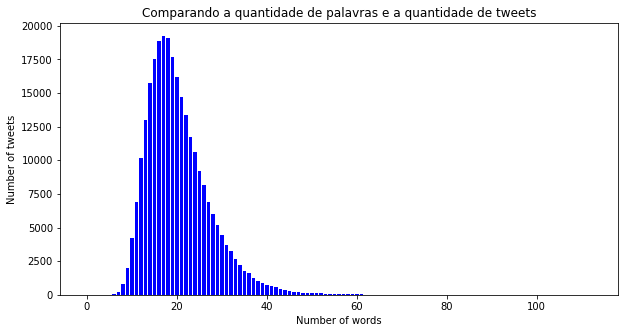

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar(hist['qtde'],hist['num texts'],
        color ='blue')
 
plt.xlabel("Number of words")
plt.ylabel("Number of tweets")
plt.title("Comparando a quantidade de palavras e a quantidade de tweets")
plt.show()

In [ ]:
# Escolho o tamanho maximo de 45 palavras por texto
max_len = 45
trunc_type = 'post'
padding_type = 'post'
train_padded = pad_sequences(train_sequences, maxlen= max_len, padding=padding_type, truncating=trunc_type)

In [ ]:
lim = 1

for i in range(lim):
  print('Texto:')
  print(df_train['hip_premise'][i])
  print('\nVetor numericalizado:')
  print(train_sequences[i])
  print('\nVetor numericalizado pós-processado com padding e truncamento:')
  print(train_padded[i])

Texto:
A child reaches up. a child reaches up into the air as a woman stands to his left and another person is seen wearing jeans to his right

Vetor numericalizado:
[1, 44, 1211, 51, 1, 44, 1211, 51, 72, 2, 129, 54, 1, 11, 86, 14, 18, 391, 7, 80, 40, 4, 782, 16, 154, 14, 18, 394]

Vetor numericalizado pós-processado com padding e truncamento:
[   1   44 1211   51    1   44 1211   51   72    2  129   54    1   11
   86   14   18  391    7   80   40    4  782   16  154   14   18  394
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]


In [ ]:
valid_sequences = tokenizer.texts_to_sequences(df_valid['hip_premise'])
test_sequences = tokenizer.texts_to_sequences(df_test['hip_premise'])

valid_padded = pad_sequences(valid_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

## Criando a Rede

In [ ]:
# model = Sequential()
# model.add(Embedding(vocab_size,output_dim=64))
# model.add(SimpleRNN(128,return_sequences=True,activation='relu'))
# # model.add(Dropout(0.5)) Pra evitar o gradiente q explode, ou cai muito
# model.add(SimpleRNN(64,activation='relu'))
# model.add(Dense(3, activaion='softmax'))

Definindo a rede. Tava recebendo um warning porque a LSTM nao cumpria algum critério (ia treinar na CPU ao invés da GPU). Mudei um pouco as coisas e assim foi.

In [ ]:
model = Sequential([
    Embedding(input_dim = len(tokenizer.word_counts), output_dim = max_len),
    LSTM(256, return_sequences=True, dropout=0.5),
    # SimpleRNN(512,return_sequences=True,activation='relu', dropout=0.5),
    # SimpleRNN(256,return_sequences=True,activation='relu', dropout=0.5),
    SimpleRNN(128,return_sequences=True,activation='relu', dropout=0.5),
    SimpleRNN(64,  activation='relu'),
    Dense(10, activation='relu'),
    Dense(5,  activation='relu'),
    Dense(4,  activation='softmax') # Pela documentacao, deveriam ter 3 classes, porem, o dataset tem 4 (???)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 45)          1255860   
                                                                 
 lstm (LSTM)                 (None, None, 256)         309248    
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 128)         49280     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 4)                 2

In [ ]:
sgd = SGD(learning_rate=0.02)
model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
history_fine = model.fit(train_padded,y_train,validation_data=(valid_padded,y_valid),epochs=10)

Epoch 1/10
8597/8597 [==============================] - 903s 104ms/step - loss: 1.1111 - accuracy: 0.3468 - val_loss: 1.1720 - val_accuracy: 0.3528
Epoch 2/10
8597/8597 [==============================] - 892s 104ms/step - loss: 1.1000 - accuracy: 0.3760 - val_loss: 1.1645 - val_accuracy: 0.3831
Epoch 3/10
8597/8597 [==============================] - 897s 104ms/step - loss: 1.0739 - accuracy: 0.4255 - val_loss: 1.1967 - val_accuracy: 0.3592
Epoch 4/10
8597/8597 [==============================] - 883s 103ms/step - loss: 1.0435 - accuracy: 0.4614 - val_loss: 1.1301 - val_accuracy: 0.4258
Epoch 5/10
8597/8597 [==============================] - 885s 103ms/step - loss: 1.0254 - accuracy: 0.4810 - val_loss: 1.1008 - val_accuracy: 0.4833
Epoch 6/10
8597/8597 [==============================] - 900s 105ms/step - loss: 1.0143 - accuracy: 0.4927 - val_loss: 1.0800 - val_accuracy: 0.4977
Epoch 7/10
Epoch 7/10
8597/8597 [==============================] - 911s 106ms/step - loss: 1.0058 - accuracy: 0.

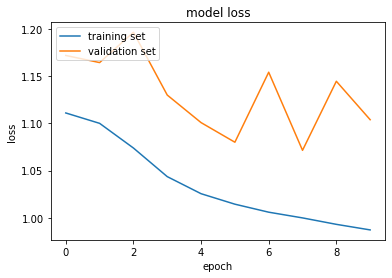

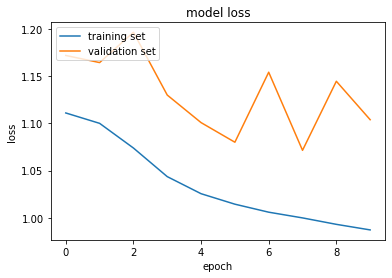

In [ ]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

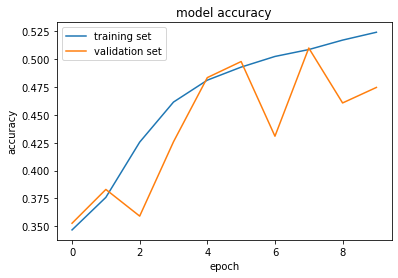

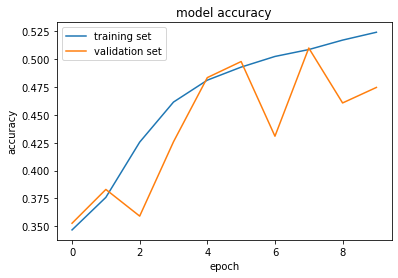

In [ ]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [ ]:
y_prob = model.predict(test_padded)
y_pred = np.argmax(y_prob,axis=1)

In [ ]:
print(classification_report(y_test_int,y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       176
           1       0.45      0.85      0.59      3368
           2       0.68      0.27      0.39      3219
           3       0.45      0.32      0.37      3237

    accuracy                           0.48     10000
   macro avg       0.64      0.36      0.34     10000
weighted avg       0.53      0.48      0.44     10000



## Salvando o Modelo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Salvando o modelo treinado

In [ ]:
model.save(filepath='/content/drive/MyDrive/temp/RNN_classifier')